# KCWI Exposure Time Calculator

Ported to Python from IDL (Chris Martin; https://www2.keck.hawaii.edu/inst/kcwi/etc.html
)

In [1]:
% matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
import os
import natsort
from scipy.interpolate import interp1d

In [2]:
def make_obj(flux, grat_wave, f_lam_index):#, w, p_A):
    w = np.arange(0,3000,1)*1.+3000.
    p_A = flux/((2.e-8)/w)*(w/grat_wave)**f_lam_index
    return w, p_A

def obj_cts(w, fo, grat, exposure_time):
    # fo = flux in ph / cm^2 /s/A
    # extinction vs. airmass not included yet
    A_geo = np.pi/4.*(10.e+2)**2
    eff = inst_throughput(w, grat)
    cts = eff*A_geo*exposure_time*fo
    return cts
    
def sky_cts(w, grat, exposure_time, airmass=False, area=False):
    airmass0 = 1.2
    if airmass:
        airmass0 = airmass
    area0 = 1.0
    if area:
        area0 = area
    A_geo = np.pi/4.*(10.e+2)**2
    eff = inst_throughput(w, grat)
    cts = eff*A_geo*exposure_time*sky_mk(w)*airmass0*area0 
    return cts

def inst_throughput(wave, grat, ang=False):
    eff_bl       = np.array([0.1825,0.38,0.40,0.46,0.47,0.44])
    eff_bm       = np.array([0.1575, 0.33, 0.36, 0.42, 0.48, 0.45])
    eff_bh1      = np.array([0., 0.0, 0.0, 0.0, 0.0, 0.])
    eff_bh2      = np.array([0.,  0.18, 0.3, 0.4, 0.28, 0.])
    eff_bh3      = np.array([0., 0., 0., 0.2, 0.29, 0.31])
    wave_0       = np.array([355.,380.,405.,450.,486.,530.])*10.
    wave_bl      = np.array([355., 530.])*10.
    wave_bm      = np.array([355., 530.])*10.
    wave_bh1     = np.array([350., 450.])*10.
    wave_bh2     = np.array([405., 486.])*10.
    wave_bh3     = np.array([405., 530.])*10.
    trans_atmtel = np.array([0.54, 0.55, 0.56, 0.56, 0.56, 0.55])

    if (grat =='BL'):
        eff = eff_bl*trans_atmtel
        wave_range = wave_bl
    elif (grat =='BM'):
        eff = eff_bm*trans_atmtel
        wave_range = wave_bm
    elif (grat =='BH1'):
        eff = eff_bh1*trans_atmtel
        wave_range = wave_bh1
    elif (grat =='BH2'):
        eff = eff_bh2*trans_atmtel
        wave_range = wave_bh2
    elif (grat =='BH3'):
        eff = eff_bh3*trans_atmtel
        wave_range = wave_bh3
    else:
        print('GRATING: %s' % grat)
        raise ValueError('\n ERROR INVALID GRATING')
    # Interpolate
    wave1 = wave
    eff_interp = interp1d(wave_0,eff,bounds_error=False,fill_value=0.0)
    eff_int = eff_interp(wave1)

    return eff_int

            #355	380	405	450	486	530
    #BL		0.1825	0.38	0.4	0.46	0.47	0.44
    #BM		0.1575	0.33	0.36	0.42	0.48	0.45
    #BH2			0.18	0.3	0.4	0.28	
    #BH3				0.2	0.29	0.31
    #ATM+TEL	0.54	0.55	0.56	0.56	0.56	0.55

def sky_mk(wave, ang=False):
    # flux from (MK?) sky in  phot/s/nm/arcsec^2/m^2
    df = pd.read_csv('mk_sky.dat',skiprows=14,names=['ws','fs'],sep=',')
    ws =  np.array(df['ws'])
    fs =  np.array(df['fs'])
    hdu = fits.open('lris_esi_skyspec_fnu_uJy.fits')
    header = hdu[0].header
    f_nu = hdu[0].data
    dw = header['CDELT1']
    w0 = header['CRVAL1']
    ns = len(f_nu)
    ws = np.arange(ns)*dw+w0

    f_lam = f_nu*(1.e-29)*(3.e+18)/ws/ws
    p_lam = f_lam/((2.e-8)/ws)
    ps_interp = interp1d(ws,p_lam,bounds_error=False,fill_value=0.0)
    ps_int = ps_interp(wave)
    return ps_int
    
def ketc(slicer, grating, grat_wave, f_lam_index, seeing, exposure_time, ccd_bin,  mag_AB=False, flux=False, Nframes=False, nas=False,
         ccd_speed=False, spatial_bin=False, spectral_bin=False, sb=False, plotout=False, emline_width=False, h = False):
    """
    INPUT:
           slicer = 'L,M,S'
           grating = 'BH1, BH2, BH3, BM, BL'
           3400. < grat_wave < 6000.
           /mag_AB = continuum AB magnitude at wavelength
           /flux = POINT: erg cm^-2 s^-1 Å^1 (continuum source [total]); erg cm^-2 s^1 (point line source [total]) [emline = width in Å]; 
                 = EXTENDED: erg cm^-2 s^-1 Å^1 arcsec^-2 (continuum source [total]); erg cm^-2 s^1 arcsec^-2 (point line source [total]) [emline = width in Å];
           /sb = m_AB in mag arcsec^2; flux = cgs arcsec^-2
            /emline_width = flux is for an emission line, not continuum flux (only works for flux), and emission line width is emline_width Å
            /spatial_bin = [dx,dy] bin in arcsec x arcsec for binning extended emission flux. if /sb keyword then default is 1 x 1 arcsec^2
            /spectral_bin = Å to bin for S/N calculation
           ccd_bin = '1x1','2x2'
           ccd_speed = 'FAST','SLOW' [Default=SLOW] ; NOT IMPLEMENTED YET
           exposure_time = seconds for source image (total) for all frames
           seeing = arcsec
           /nas=minutes per exposure -- assume exposure_time is total, account for 1/2 Source, 1/2 Sky, Sky subtraction noise, overhead
            /Nframes = number of frames (default is 1)

    OUTPUT:
           p_A = is the total cgs flux of point or extended object
           SNR vs. wavelength; Object cts vs. wavelength, Sky cts vs. wavelength; Read noise "cts"; contrast vs. wavelength

    NOTES:
            converts everything to a surface brightness / Å
    """
    
    if h:
        print('ketc, slicer, grating, ref_wave, f_lam_index, seeing, exposure time, ccd_bin, mag_AB=mag_AB, flux=flux, Nframes=Nframes, nas=nas,')
        print('   spatial_bin=spatial_bin, spectral_bin=spectral_bin, sb=sb, plotout=plotout, emline_width=emline_width')
        print('')
        print("slicer = 'L,M,S'")
        print("grating = 'BH1, BH2, BH3, BM, BL'")
       	print('3400. < ref_wave < 6000.')
        print('f_lam_index: source f_lam ~ lam^f_lam_index')
        print('exposure_time = seconds for source image (total) for all frames')
        print('seeing = arcsec')
        print('/mag_AB = continuum AB magnitude at wavelength (ref_wave)')
        print('/flux = POINT: erg cm^-2 s^-1 Å^1 (continuum source [total]); erg cm^-2 s^1 (point line source [total]) [emline = width in Å];')
        print('       = EXTENDED: erg cm^-2 s^-1 Å^1 arcsec^-2 (continuum source [total]); erg cm^-2 s^1 arcsec^-2 (point line source [total]) [emline = width in Å];')
        print('/sb = m_AB in mag arcsec^2; flux = cgs arcsec^-2')
        print('/emline_width = flux is for an emission line, not continuum flux (only works for flux), and emission line width is emline_width Å')
        print('/spatial_bin = [dx,dy] bin in arcsec x arcsec for binning extended emission flux. if /sb keyword then default is 1 x 1 arcsec^2')
        print('/spectral_bin = Å to bin for S/N calculation')
        print("ccd_bin = '1x1','2x2'")
#       print( ccd_speed = 'FAST','SLOW' [Default=SLOW] ; NOT IMPLEMENTED YET
        print('/nas=minutes per exposure -- assume exposure_time is total, account for 1/2 Source, 1/2 Sky, Sky subtraction noise, overhead')
        print('/Nframes = number of frames (default is 1)')

    # Check binning factor
    bin_factor = 1.
    if (ccd_bin == '2x2'):
        bin_factor = 0.25
    if (ccd_bin == '2x2') and (slicer == 'S'):
        raise ValueError('\n ******** WARNING: DO NOT USE 2x2 BINNING WITH SMALL SLICER! \n')

    read_noise = 2.7 # units of electrons
    Nf = 1.
    if Nframes: Nf = Nframe
    chsz = 3
    nas_overhead = 10. # seconds per half cycle
    seeing1 = seeing
    seeing2 = seeing
    pixels_per_arcsec = 1./0.147
    if (slicer == 'L'):
        seeing2 = 1.38
        snr_spatial_bin = seeing1*seeing2
        pixels_spectral = 8
        arcsec_per_slice = 1.35
    if (slicer == 'M'):
        seeing2 = np.max([0.69,seeing])
        snr_spatial_bin = seeing1*seeing2
        pixels_spectral = 4
        arcsec_per_slice = 0.69
    if (slicer == 'S'):
        seeing2 = seeing
        snr_spatial_bin = seeing1*seeing2
        pixels_spectral = 2
        arcsec_per_slice = 0.35
    N_slices = seeing/arcsec_per_slice

    if spatial_bin:
        N_slices = spatial_bin[1]/arcsec_per_slice
        snr_spatial_bin = spatial_bin[0]*spatial_bin[1]
    pixels_spatial_bin = pixels_per_arcsec * N_slices

    if (grating == 'BL'):
        A_per_pixel = 0.625
    if (grating == 'BM'):
        A_per_pixel = 0.28
    if (grating == 'BH2') or (grating == 'BH3'):
        A_per_pixel = 0.125
        
    print('f_lam ~ lam^%s' % f_lam_index)
    print('reference wavelength = %s'% grat_wave)
    print('SLICER: %s'% slicer)
    print('GRATING: %s'% grating)
    print('SEEING: %s arcsec' % seeing)
    print('Å/pixel: %s'% A_per_pixel)
    print('spectral pixels in 1 spectral resolution element = %s' % pixels_spectral)
    A_per_spectral_bin = pixels_spectral*A_per_pixel
    print('Å/resolution element: %s' % A_per_spectral_bin)
    if spectral_bin:
        snr_spectral_bin = spectral_bin
    else:
        snr_spectral_bin = A_per_spectral_bin
    print('Å/SNR bin: %s' % snr_spectral_bin)
    pixels_per_snr_spec_bin = snr_spectral_bin/A_per_pixel
    print('Pixels/Spectral SNR bin: %s' % pixels_per_snr_spec_bin)
    print('SNR Spatial Bin [arcsec^2]: %s' % snr_spatial_bin)
    print('SNR Spatial Bin [pixels^2]: %s' % pixels_spatial_bin)
        
    flux1 = 0
    if flux: flux1 = flux
    if flux and emline_width: flux1 = flux/emline_width
    if not flux and emline_width:
        raise ValueError('\n Dont use mag_AB for emission line!\n')
    if mag_AB:
        flux1 = (10**(-0.4*(mag_AB+48.6)))*((3.e+18)/grat_wave)/grat_wave

    # Call make_obj()
    w, p_A = make_obj(flux1,grat_wave, f_lam_index)#,w, p_A)

    if mag_AB and not sb:
        flux_input = 'mag_AB'
        print('\n OBJECT mag: %s     %s' % (mag_AB,flux_input) )
    if mag_AB and sb:
        flux_input = 'mag_AB / arcsec^2'
        print('\n OBJECT mag: %s     %s' % (mag_AB,flux_input) )
    
    if flux and not sb and not emline_width:
        flux_input = 'erg cm^-2 s^-1 Å^-1'
    if flux and not sb and emline_width:
        flux_input = 'erg cm^-2 s^-1 in %0.1f Å' % emline_width
    if flux and sb and not emline_width:
        flux_input = 'erg cm^-2 s^-1 Å^-1 arcsec^-2'
    if flux and sb and emline_width:
        flux_input = 'erg cm^-2 s^-1 arcsec^-2 in %0.1f Å' % emline_width
    if flux:
        print('OBJECT Flux %s       %s' % (flux,flux_input) )
    if emline_width:
        print('\n EMISSION LINE OBJECT --> flux is not per unit Å \n')

    # Calculate Read Noise
    # Need to determine pixels per spectral and spatial bin
    # 1 unbinned pixel = 0.147 arcsec in both dimensions (no significant difference in grating angles
    # 1 pixel spectral depends on grating: slicer BH L = 8 CCD pixels per spectral element = 4500/4500 = 1Å; M = 0.5Å; S = 0.25Å
    # 1 pixel spectral depends on grating: slicer BM L = 8 CCD pixels per spectral element = 4500/2000 = 2.4Å; M = 1.2Å; S = 0.6Å
    # 1 pixel spectral depends on grating: slicer BL L = 8 CCD pixels per spectral element = 4500/900 = 5Å; M = 2.5Å; S = 1.25Å

    t_exp = exposure_time
    if not nas:
        c_o = obj_cts(w,p_A,grating,t_exp)*snr_spatial_bin*snr_spectral_bin
        c_s = sky_cts(w,grating,exposure_time)*snr_spatial_bin*snr_spectral_bin
        c_r = Nf*read_noise**2*pixels_per_snr_spec_bin*pixels_spatial_bin*bin_factor
        snr = c_o/np.sqrt(c_s+c_o+c_r)
    if nas:
        n_cyc = ((exposure_time-nas_overhead)/2./(nas+nas_overhead)+0.5)
        n_cyc = np.array(n_cyc).astype(int)
        total_exposure = (2*n_cyc*(nas+nas_overhead))+nas_overhead
        print('\n NAS: Rounding up to %s Cycles of NAS for total exposure of %s s' % (n_cyc,total_exposure) )
        t_exp = n_cyc*nas
        c_o = obj_cts(w,p_A,grating,t_exp)*snr_spatial_bin*snr_spectral_bin
        c_s = sky_cts(w,grating,t_exp)*snr_spatial_bin*snr_spectral_bin
        c_r = 2.*Nf*read_noise**2*pixels_per_snr_spec_bin*pixels_spatial_bin*bin_factor
        snr = c_o/np.sqrt(2.*c_s+c_o+c_r)
    
    # Plot
    if (plotout == True):
        y0 = 0.1
        y1 = 0.9
        dy = (y1-y0)/6.
        chsz=1.
        fig = plt.figure(figsize=(12,10)) 
        gs = gridspec.GridSpec(6, 1)
        gs.update(wspace=0.1, hspace=0.35) # set the spacing between axes. 

        ax1  = fig.add_subplot(gs[0:1,0]) # Plot of H-beta region & fits
        ax2  = fig.add_subplot(gs[1:2,0])
        ax3  = fig.add_subplot(gs[2:3,0])
        ax4  = fig.add_subplot(gs[3:4,0])
        ax5  = fig.add_subplot(gs[4:5,0])
        ax6  = fig.add_subplot(gs[5:6,0])
        
        
        ax1.plot(w,snr,label='S/N = %0.1f' % np.median(snr))
        ax1.set_ylabel(r'SNR /%0.2f $\rm{\AA}$' % (snr_spectral_bin) )
        ax1.set_xlabel(r'Wavelength,$\lambda$ ($\rm{\AA}$)')
        ax1.set_xlim(np.min(w),np.max(w))
        ax1.legend(loc='upper right')
        ax1.set_ylim(0,np.max(snr)+0.10*np.max(snr))
        
        ax2.plot(w,c_o)
        ax2.set_ylabel(r'Obj cts /%0.2f $\rm{\AA}$' % (snr_spectral_bin) )
        ax2.set_xlabel(r'Wavelength,$\lambda$ ($\rm{\AA}$)')
        ax2.set_xlim(np.min(w),np.max(w))
        ax2.set_ylim(0,np.max(c_o)+0.10*np.max(c_o))
        
        ax3.plot(w,c_s)
        ax3.set_ylabel(r'Sky cts /%0.2f $\rm{\AA}$' % (snr_spectral_bin) )
        ax3.set_xlabel(r'Wavelength,$\lambda$ ($\rm{\AA}$)')
        ax3.set_xlim(np.min(w),np.max(w))
        ax3.set_ylim(0,np.max(c_s)+0.10*np.max(c_s))

        ax4.plot(w,c_r*np.full(len(w),1.0))
        ax4.set_ylabel(r'Read Noise cts /%0.2f $\rm{\AA}$' % (snr_spectral_bin) )
        ax4.set_xlabel(r'Wavelength,$\lambda$ ($\rm{\AA}$)')
        ax4.set_xlim(np.min(w),np.max(w))
        ax4.set_ylim(0,np.max(c_r*np.full(len(w),1.0))+0.10*np.max(c_r*np.full(len(w),1.0)))

#         ax5.plot(w,c_o/c_s,ytitle='Obj cts / Sky cts',charsize=chsz,pos=[0.15,y1-5*dy,0.9,y1-4*dy],/noerase)
        ax5.plot(w,np.nan_to_num(c_o/c_s))
        ax5.set_ylabel(r'$c_{\rm{obj}}/c_{\rm{sky}}$' )
        ax5.set_xlabel(r'Wavelength,$\lambda$ ($\rm{\AA}$)')
        ax5.set_xlim(np.min(w),np.max(w))
        ax5.set_ylim(0,np.max(np.nan_to_num(c_o/c_s))+0.10*np.max(np.nan_to_num(c_o/c_s)))
        
        ax6.plot(w,p_A)
        ax6.set_ylabel(r'Flux [ph cm$^{-2}$ s$^{-1}$ $\rm{\AA}^{-1}$]')
        ax6.set_xlabel(r'Wavelength,$\lambda$ ($\rm{\AA}$)')
        ax6.set_xlim(np.min(w),np.max(w))
        ax6.set_ylim(0,np.max(p_A)+0.10*np.max(p_A))
        
        gs.tight_layout(fig)
        
    return None

# Examples from https://www2.keck.hawaii.edu/inst/kcwi/etc.html

### 1. Point Source

f_lam ~ lam^0.0
reference wavelength = 4500.0
SLICER: S
GRATING: BL
SEEING: 0.75 arcsec
Å/pixel: 0.625
spectral pixels in 1 spectral resolution element = 2
Å/resolution element: 1.25
Å/SNR bin: 1.25
Pixels/Spectral SNR bin: 2.0
SNR Spatial Bin [arcsec^2]: 0.5625
SNR Spatial Bin [pixels^2]: 14.5772594752

 OBJECT mag: 23.0     mag_AB


<IPython.core.display.Javascript object>


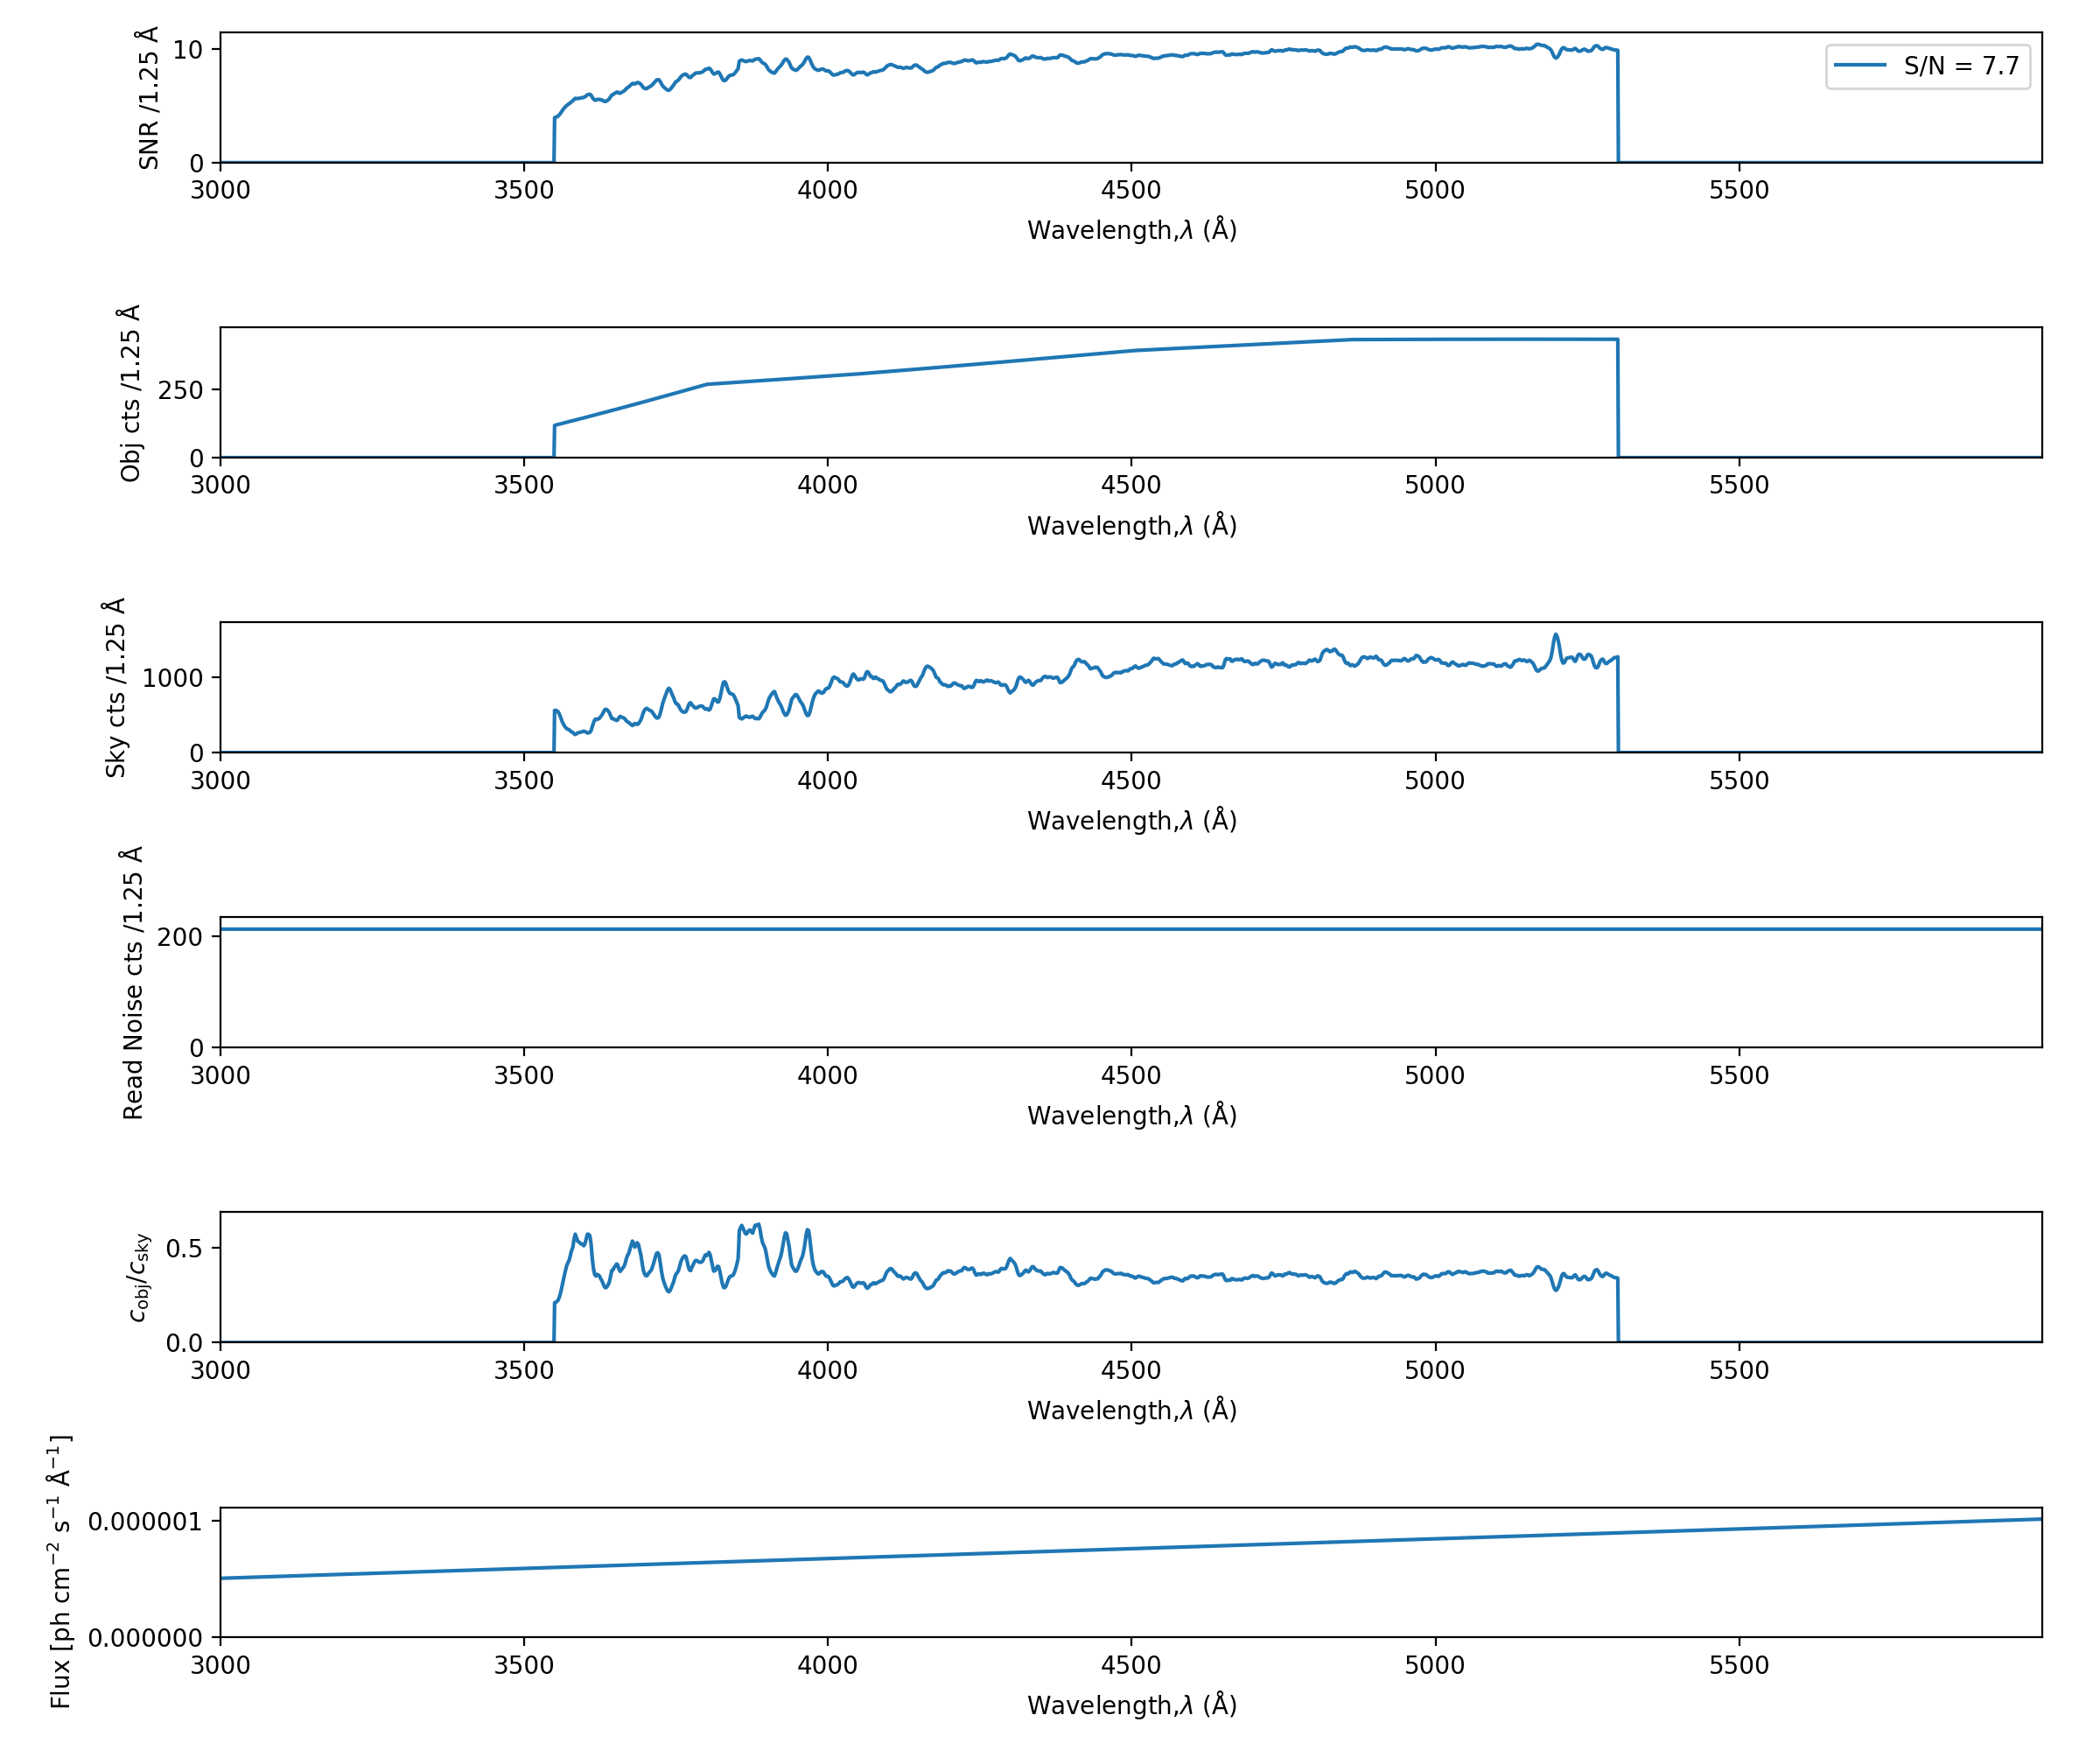

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:304: RuntimeWarning: invalid value encountered in divide
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:308: RuntimeWarning: invalid value encountered in divide


In [3]:

ketc('S','BL', 4500., 0.,0.75,3600.,'1x1',mag_AB=23.,plotout=True)


### 2.Point source 22AB Small slicer, BM grating


f_lam ~ lam^0.0
reference wavelength = 4500.0
SLICER: S
GRATING: BM
SEEING: 0.75 arcsec
Å/pixel: 0.28
spectral pixels in 1 spectral resolution element = 2
Å/resolution element: 0.56
Å/SNR bin: 0.56
Pixels/Spectral SNR bin: 2.0
SNR Spatial Bin [arcsec^2]: 0.5625
SNR Spatial Bin [pixels^2]: 14.5772594752

 OBJECT mag: 22.0     mag_AB


<IPython.core.display.Javascript object>


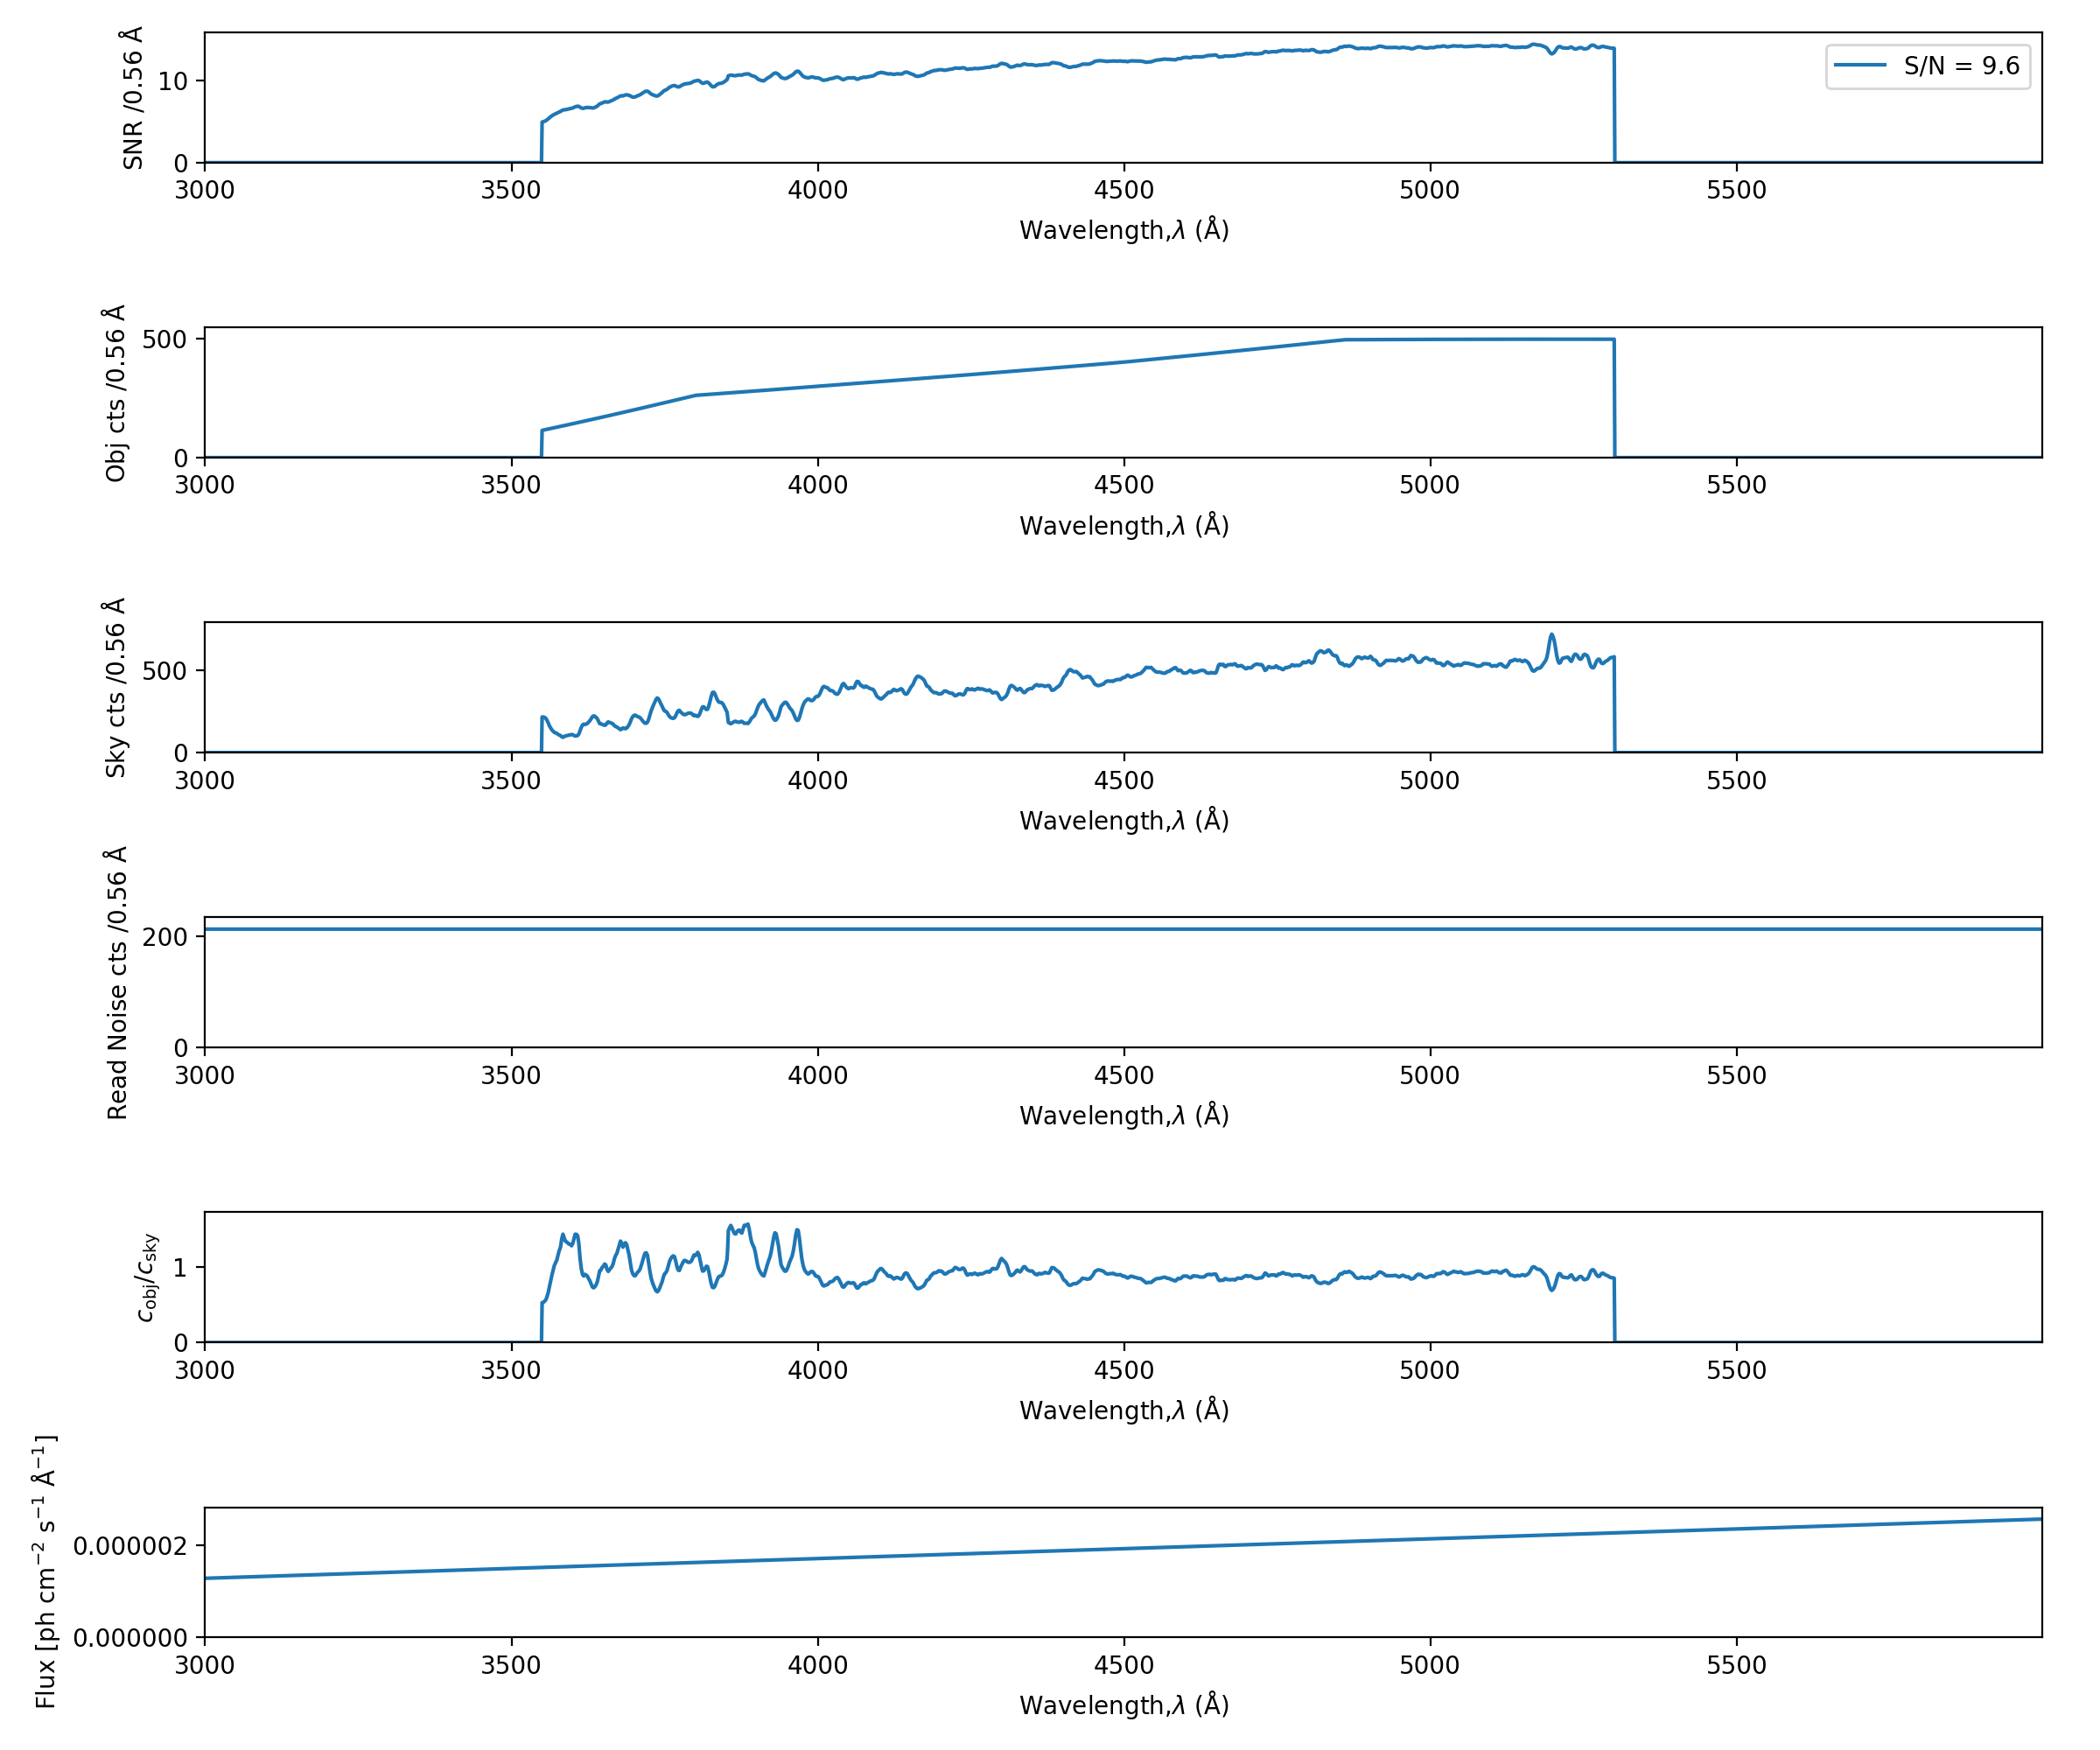

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:304: RuntimeWarning: invalid value encountered in divide
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:308: RuntimeWarning: invalid value encountered in divide


In [4]:
ketc('S', 'BM', 4500., 0.,0.75,3600.,'1x1',mag_AB=22.,plotout=True)

 ### 3. point source 20AB, Small slicer, BH2 grating

f_lam ~ lam^0.0
reference wavelength = 4500.0
SLICER: S
GRATING: BH2
SEEING: 0.75 arcsec
Å/pixel: 0.125
spectral pixels in 1 spectral resolution element = 2
Å/resolution element: 0.25
Å/SNR bin: 0.25
Pixels/Spectral SNR bin: 2.0
SNR Spatial Bin [arcsec^2]: 0.5625
SNR Spatial Bin [pixels^2]: 14.5772594752

 OBJECT mag: 20.0     mag_AB


<IPython.core.display.Javascript object>


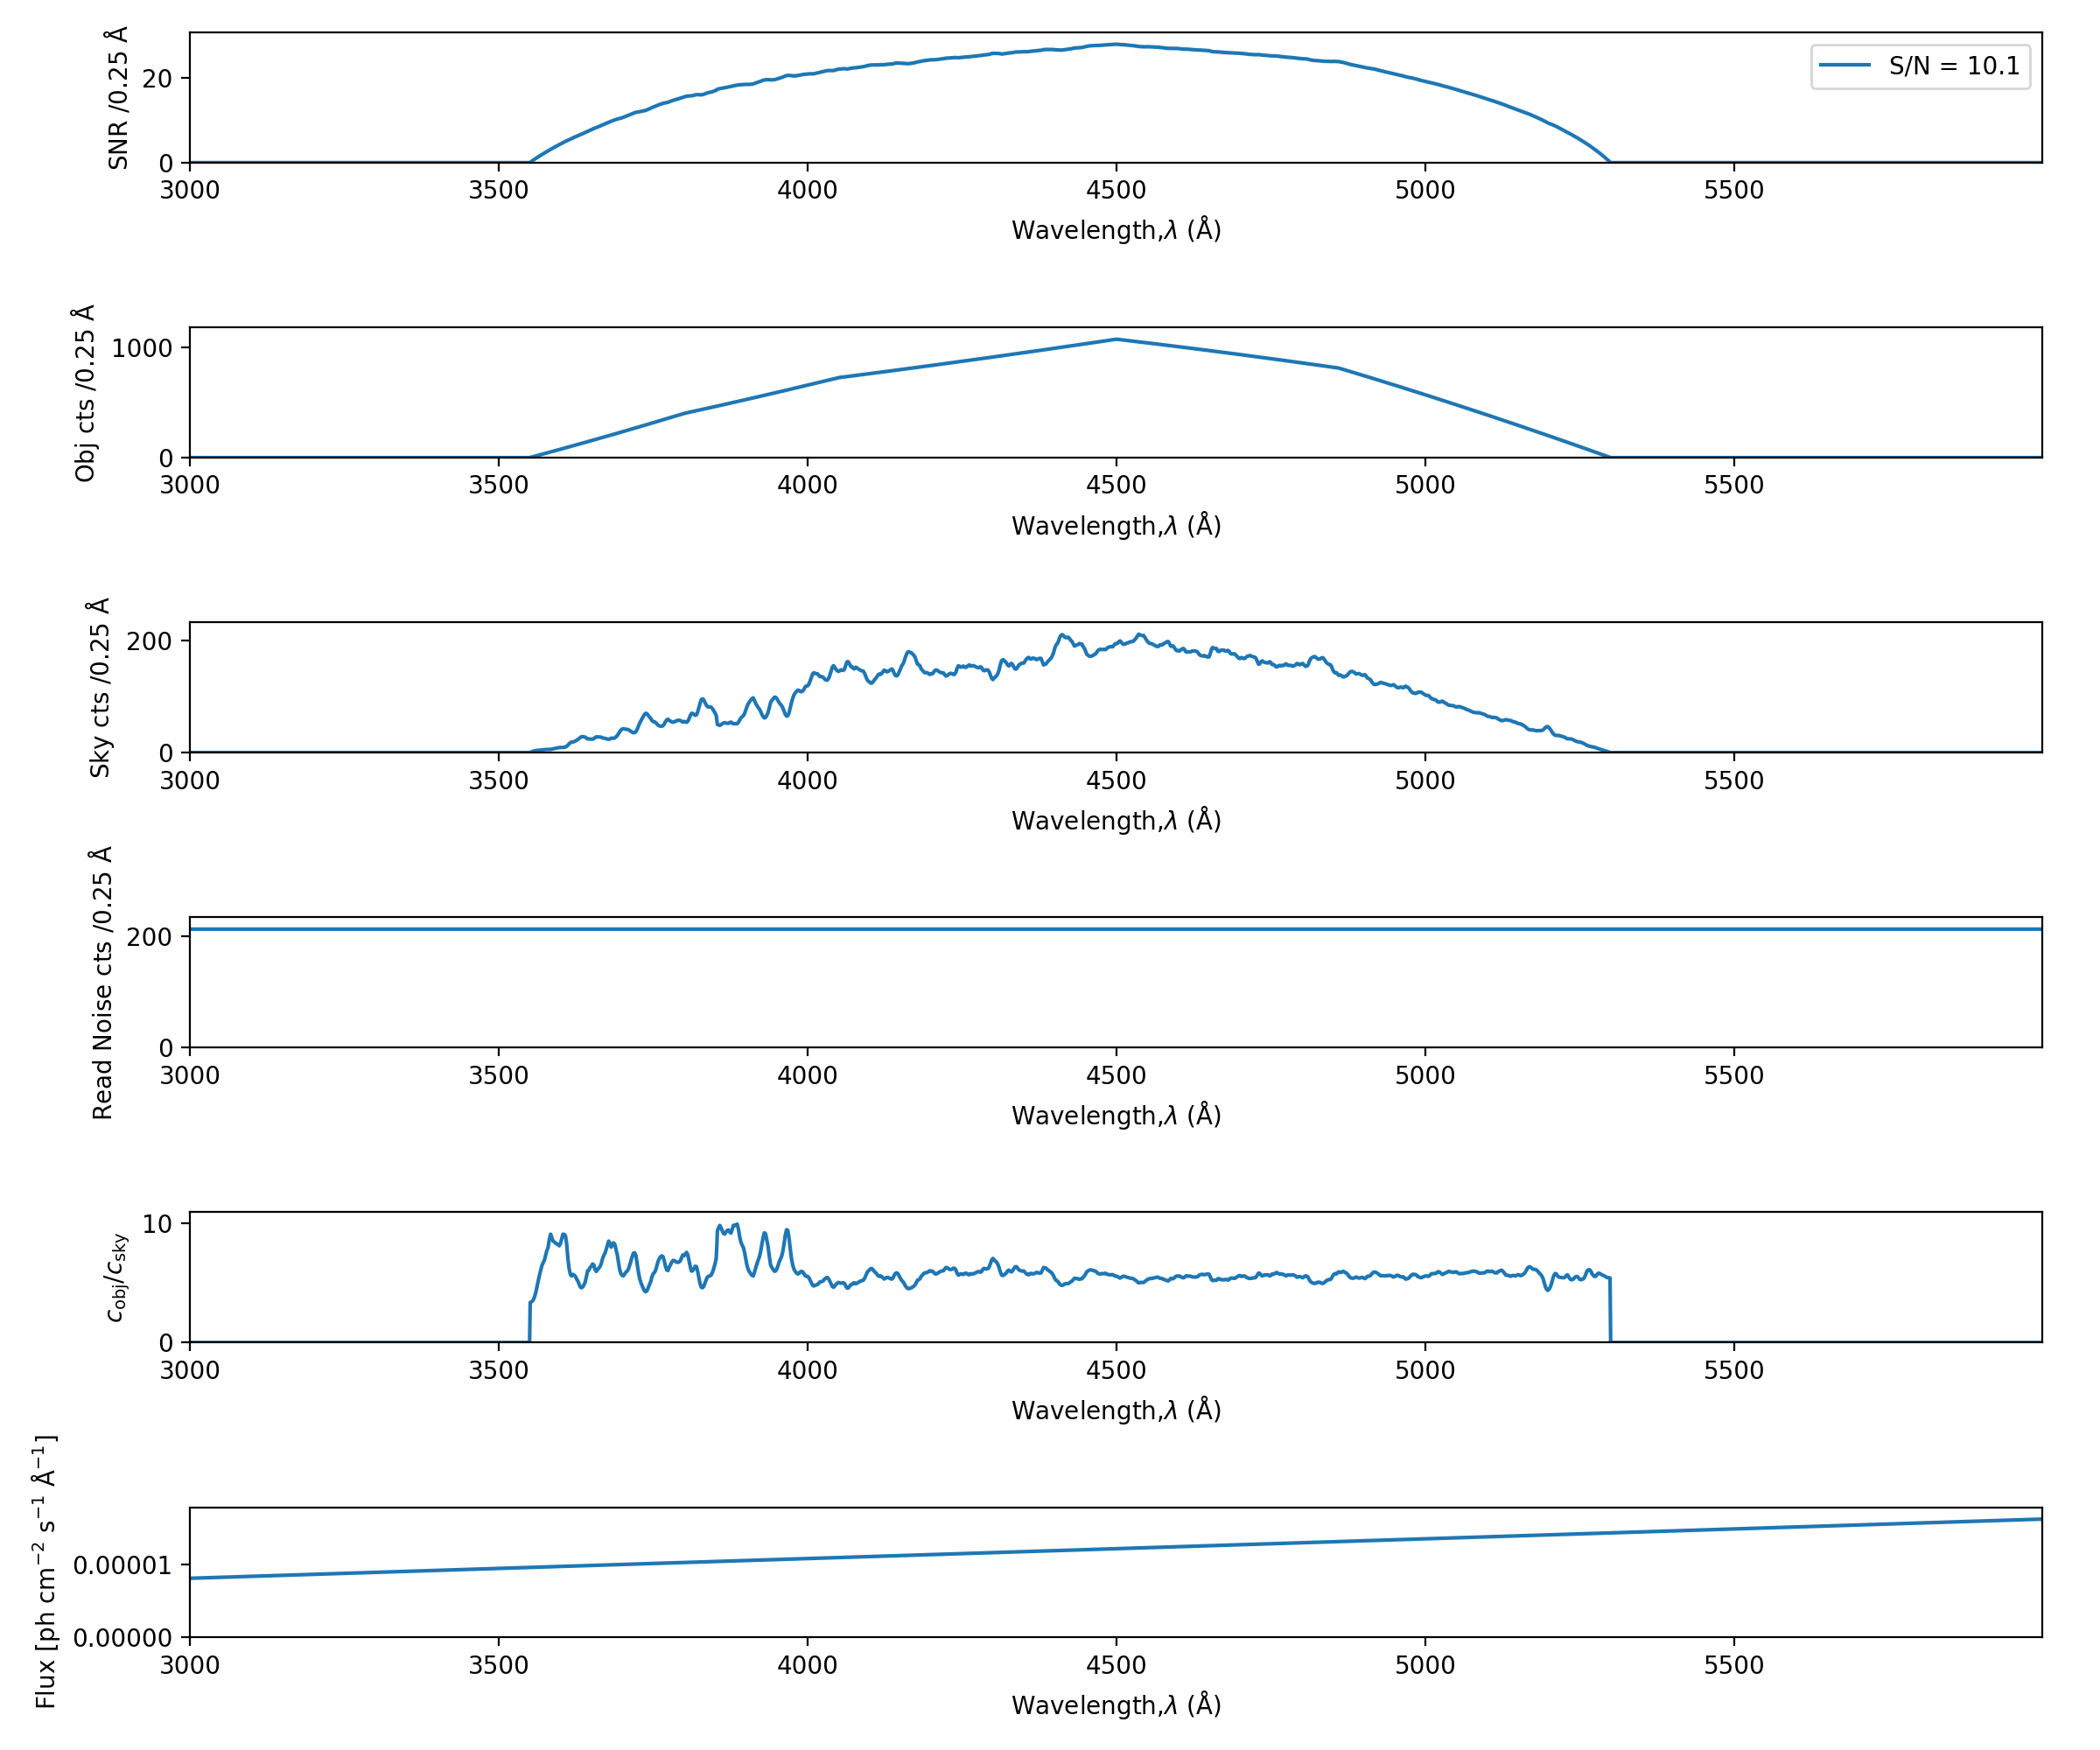

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:304: RuntimeWarning: invalid value encountered in divide
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:308: RuntimeWarning: invalid value encountered in divide


In [5]:
ketc('S', 'BH2', 4500., 0.,0.75,3600.,'1x1',mag_AB=20.,plotout=True)

#### 5. Extended object, flux=1e-17 erg cm^-2 s^-1 arcsec^-2, emission line with linewidth=10Å, Large slicer, BL grating, 3600 s, 2” x 2” bins.

f_lam ~ lam^0.0
reference wavelength = 4500.0
SLICER: L
GRATING: BL
SEEING: 0.75 arcsec
Å/pixel: 0.625
spectral pixels in 1 spectral resolution element = 8
Å/resolution element: 5.0
Å/SNR bin: 5.0
Pixels/Spectral SNR bin: 8.0
SNR Spatial Bin [arcsec^2]: 4.0
SNR Spatial Bin [pixels^2]: 10.0781053162
OBJECT Flux 1e-17       erg cm^-2 s^-1 in 10.0 Å

 EMISSION LINE OBJECT --> flux is not per unit Å 



<IPython.core.display.Javascript object>


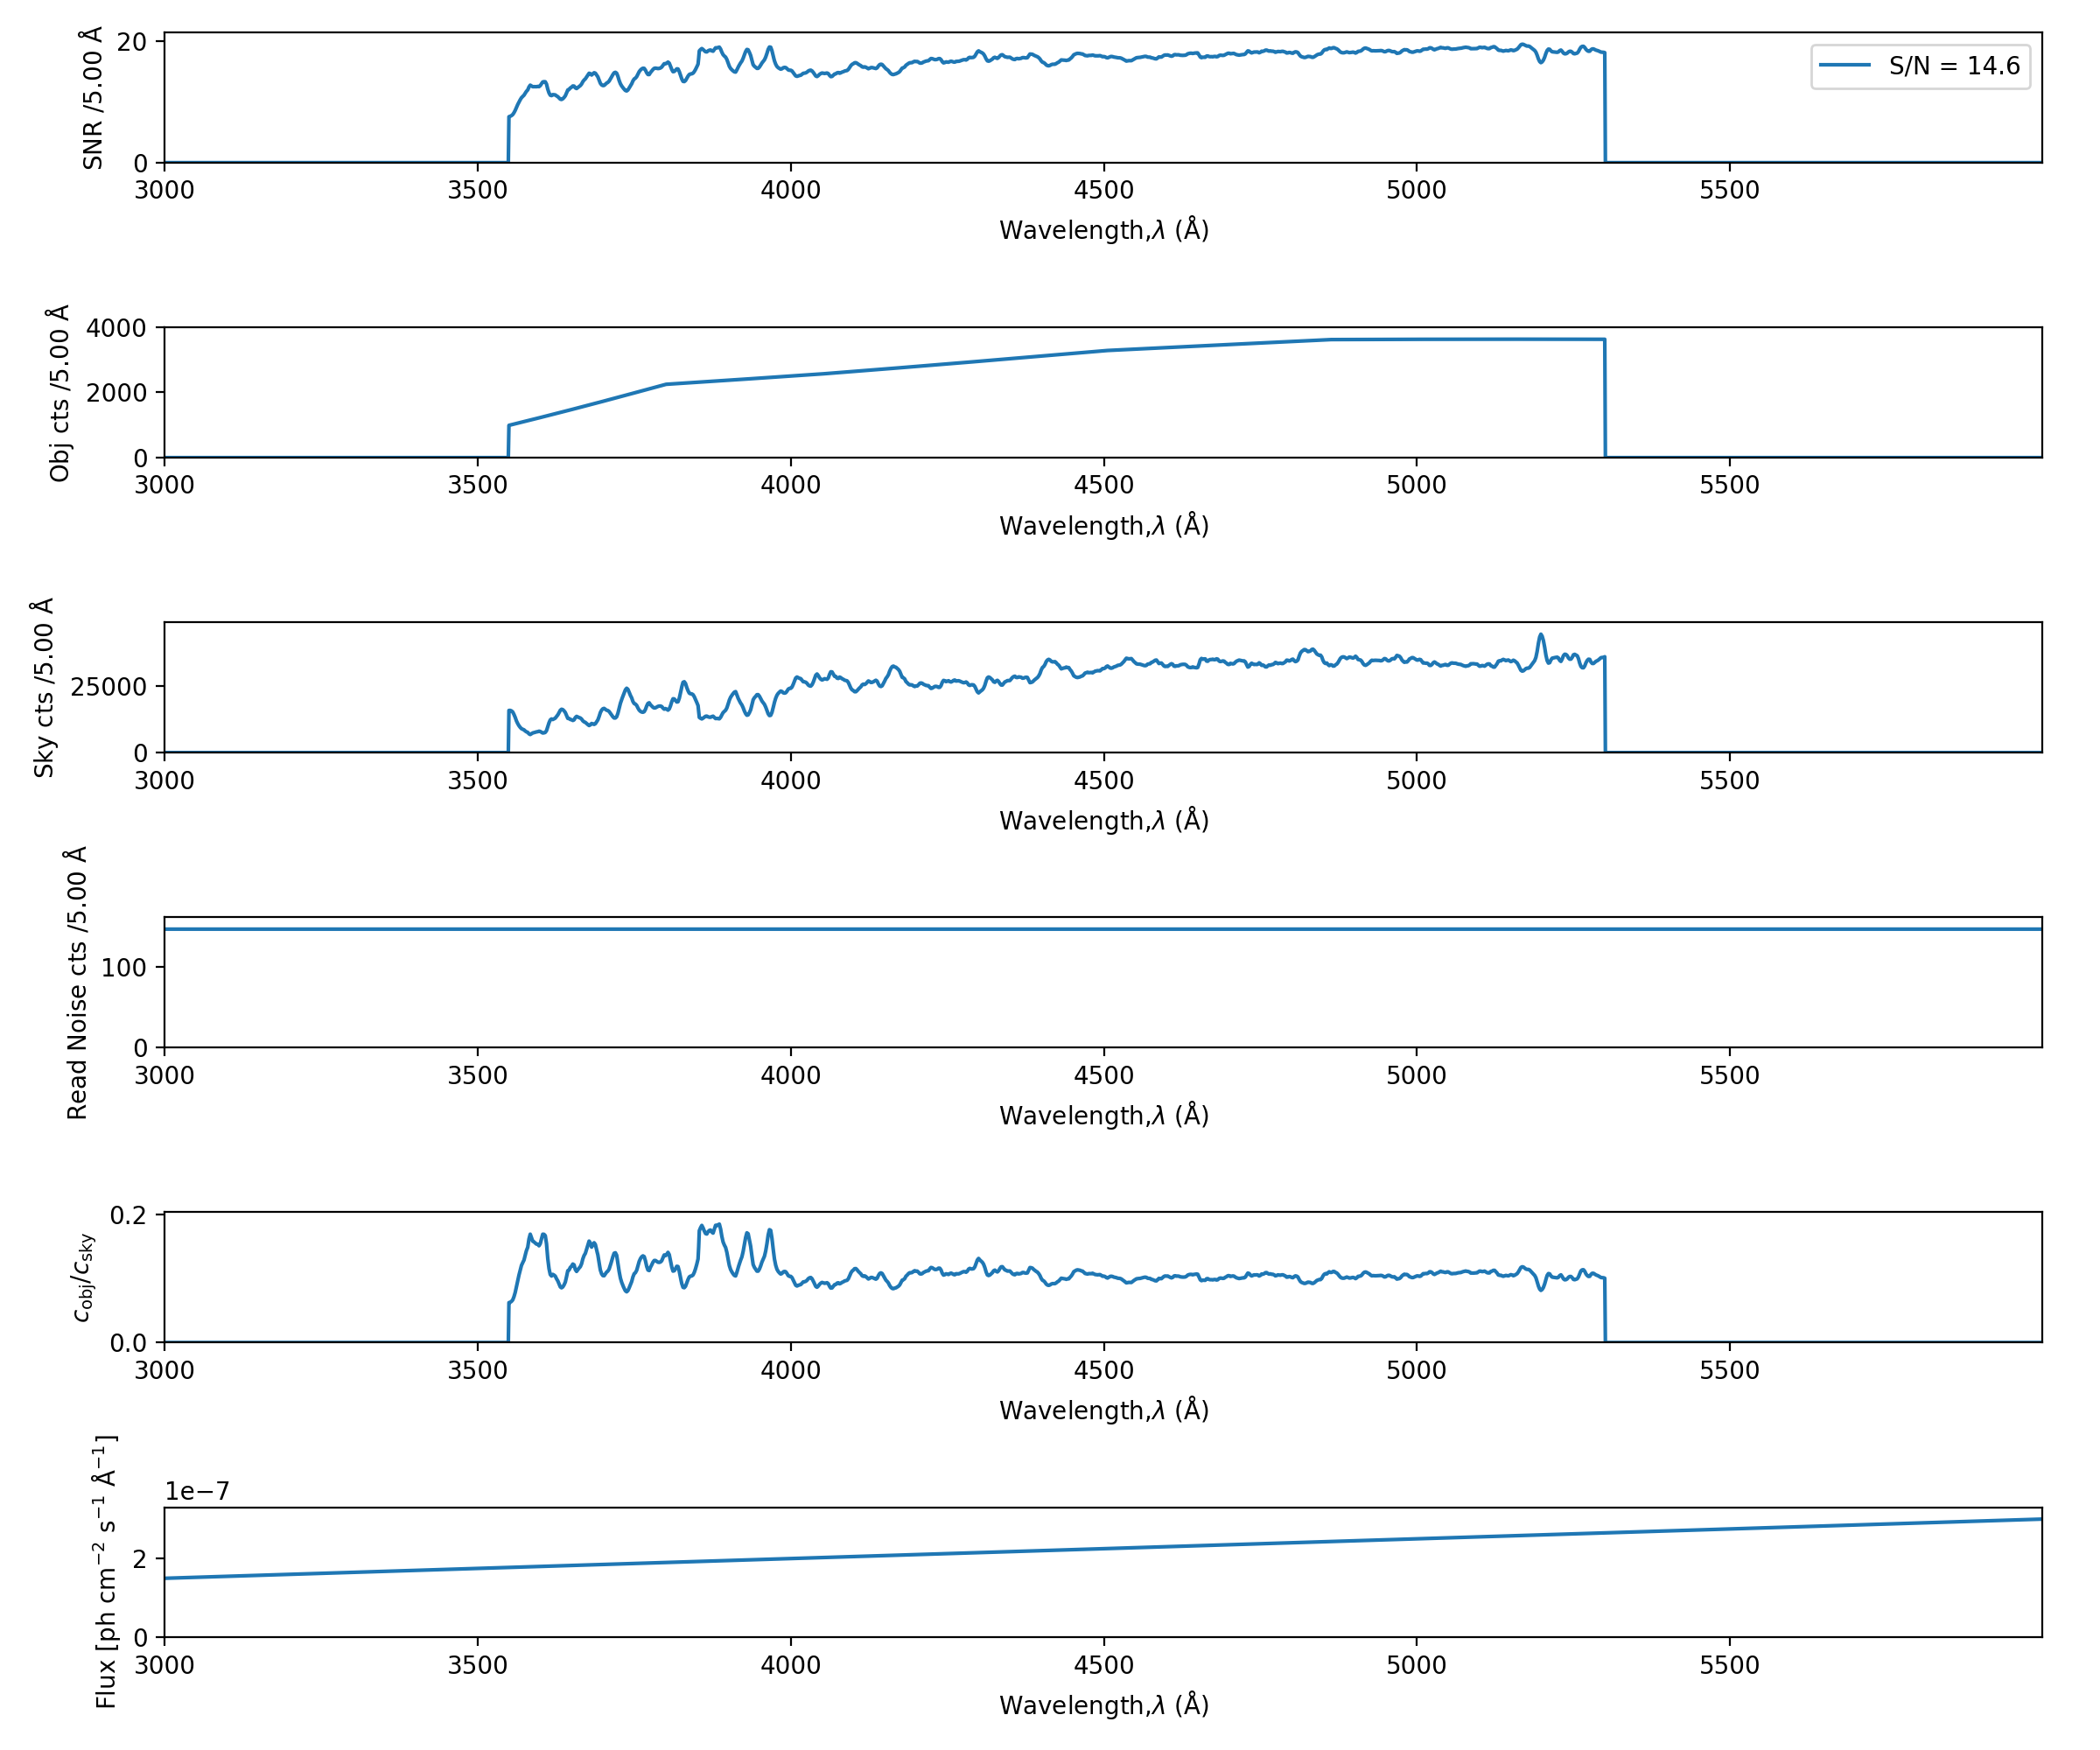

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:304: RuntimeWarning: invalid value encountered in divide
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:308: RuntimeWarning: invalid value encountered in divide


In [6]:
ketc('L', 'BL', 4500., 0.,0.75,3600.,'2x2',flux=1.e-17,emline_width=10.,spatial_bin=[2.,2.],plotout=True)

### 6. Same as 5. with Nod-and-shuffle

f_lam ~ lam^0.0
reference wavelength = 4500.0
SLICER: L
GRATING: BL
SEEING: 0.75 arcsec
Å/pixel: 0.625
spectral pixels in 1 spectral resolution element = 8
Å/resolution element: 5.0
Å/SNR bin: 5.0
Pixels/Spectral SNR bin: 8.0
SNR Spatial Bin [arcsec^2]: 4.0
SNR Spatial Bin [pixels^2]: 10.0781053162
OBJECT Flux 1e-17       erg cm^-2 s^-1 in 10.0 Å

 EMISSION LINE OBJECT --> flux is not per unit Å 


 NAS: Rounding up to 14 Cycles of NAS for total exposure of 3650.0 s


<IPython.core.display.Javascript object>


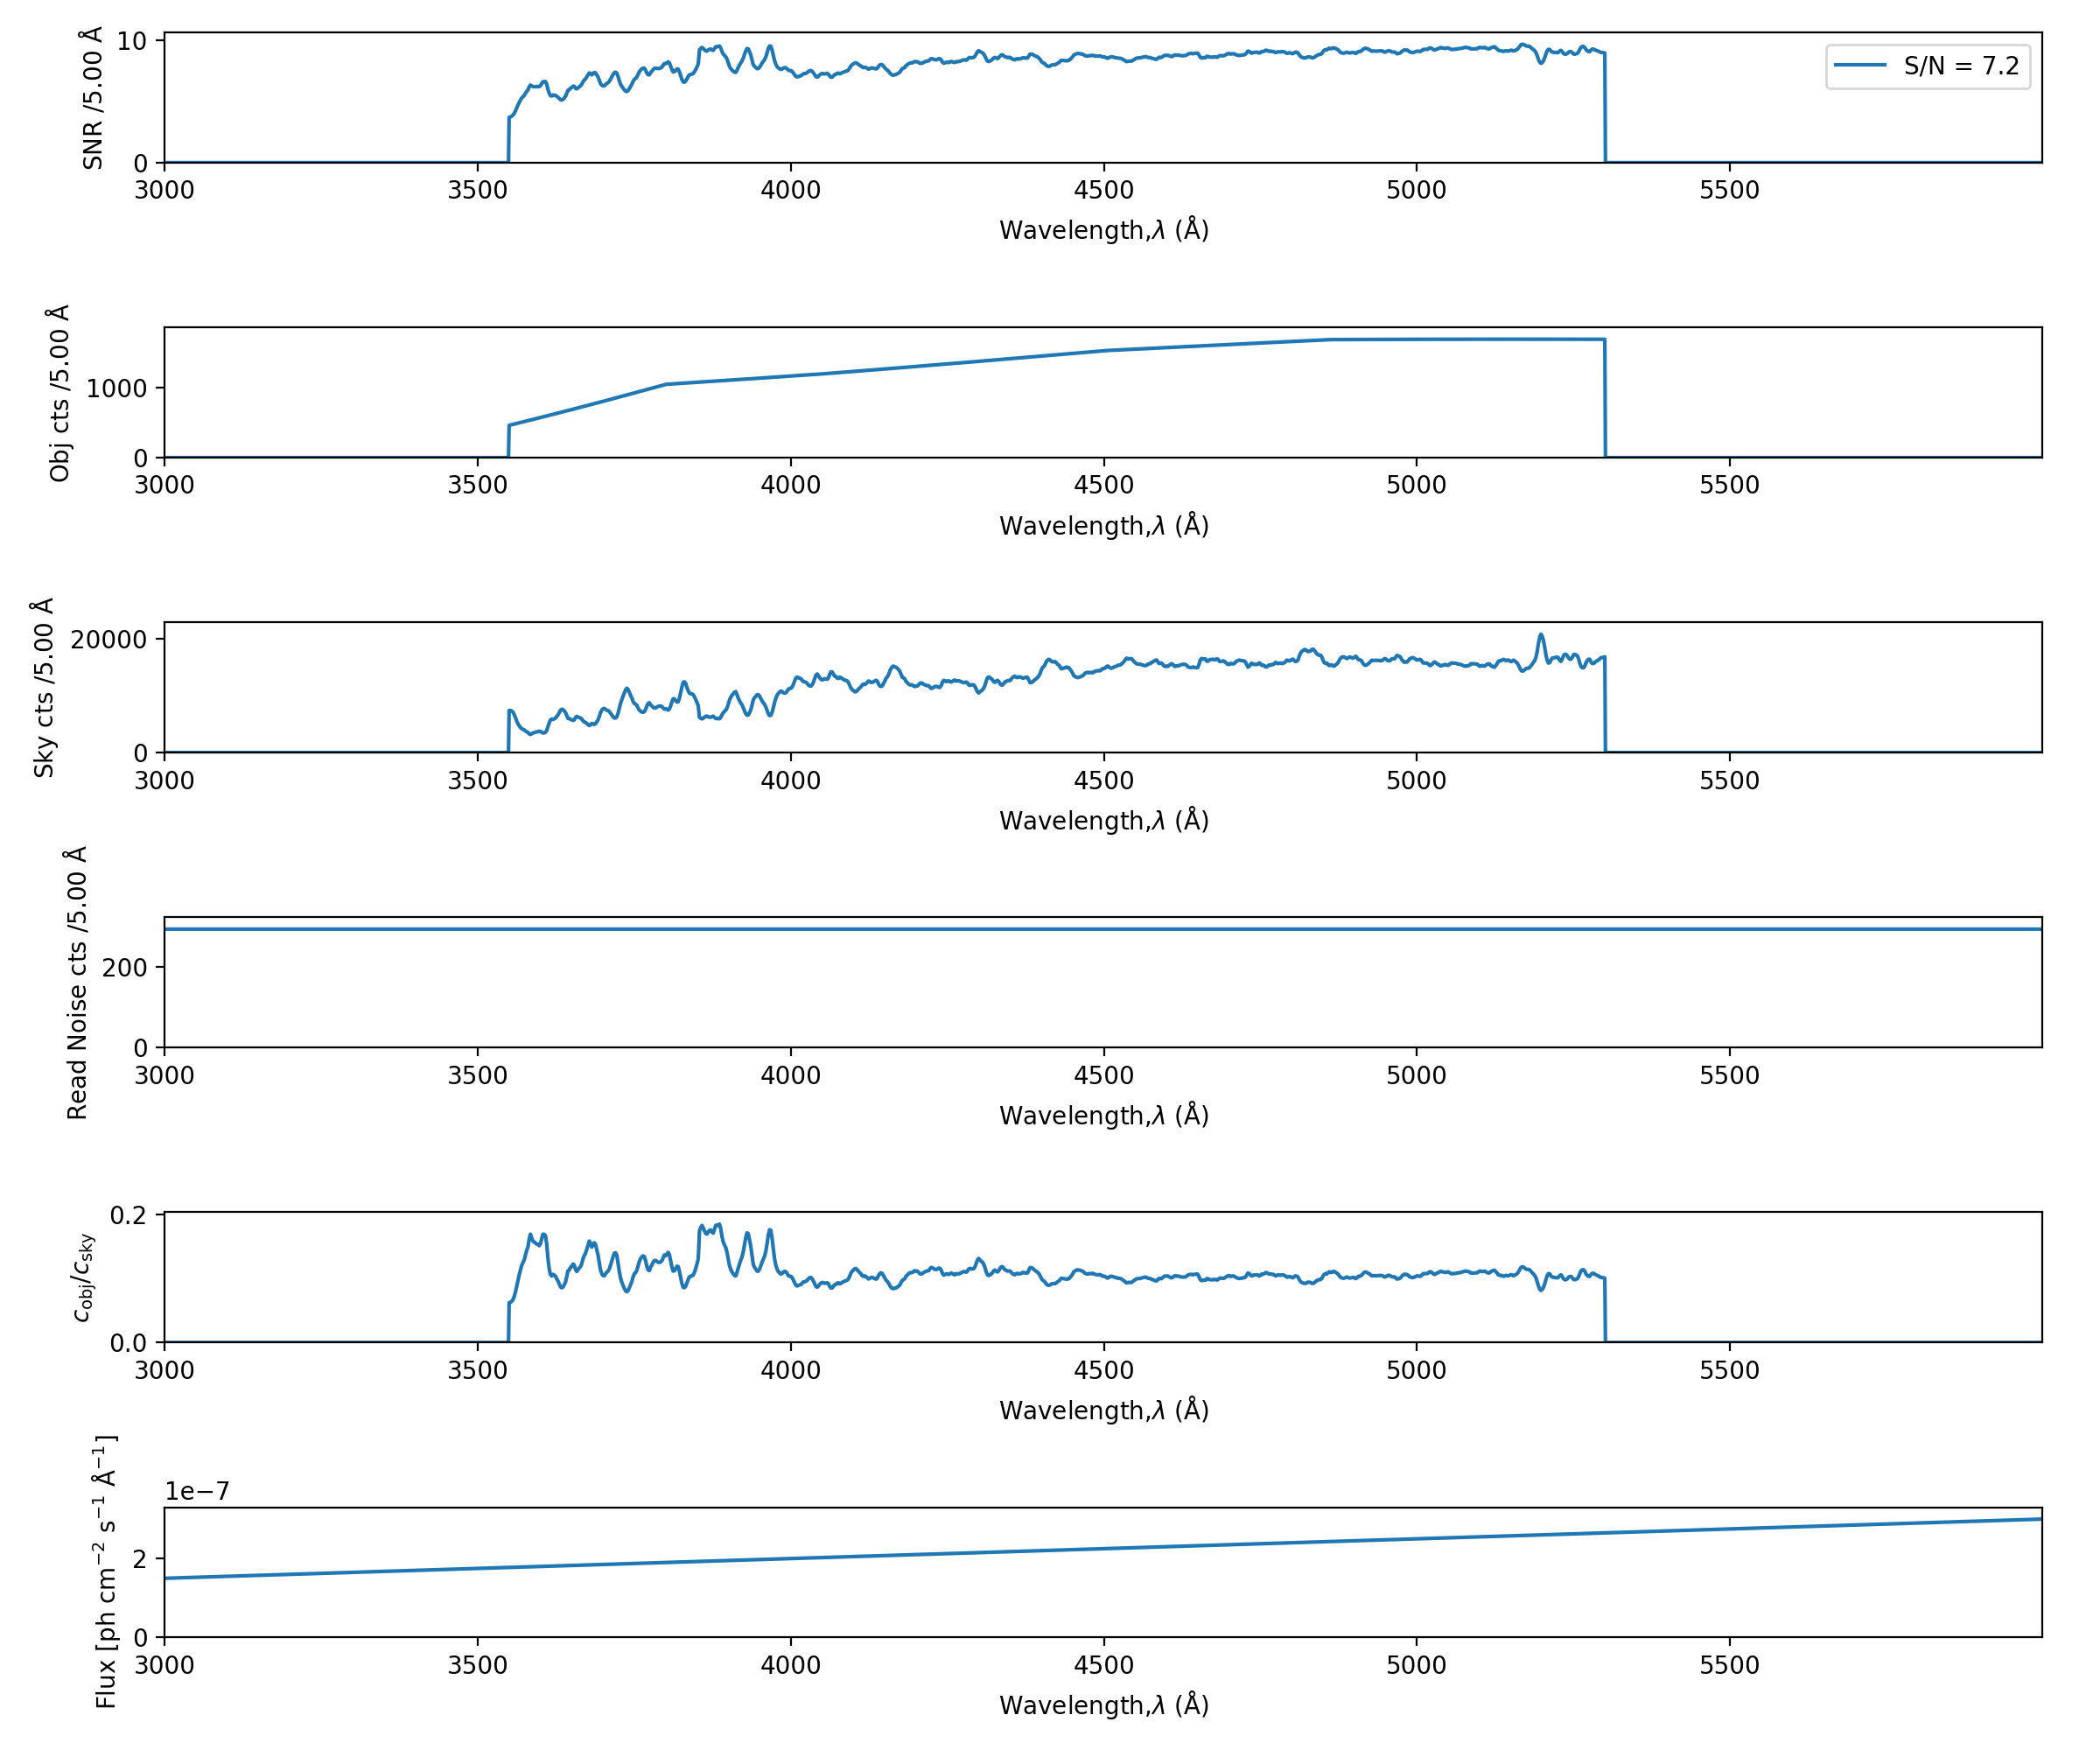

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:304: RuntimeWarning: invalid value encountered in divide
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:308: RuntimeWarning: invalid value encountered in divide


In [7]:
ketc('L', 'BL', 4500., 0.,0.75,3600.,'2x2',flux=1.e-17,emline_width=10.,spatial_bin=[2.,2.],plotout=True,nas=120.)